In [9]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from llm import LLM


# Example datasets

## ITSM -small

In [10]:
itsm_df = pd.read_csv('../datasets/itsm.csv')
# select non empty rows
itsm_df_focused = itsm_df[['Text', 'Category']].fillna('EMPTY')
itsm_df_focused.head()
itsm_df_focused.shape

(118, 2)

## Youtube comments

In [11]:
yt_df = pd.read_csv('../datasets/yt_comments.csv')
yt_df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


## Students performance

In [12]:
students_df = pd.read_csv('../datasets/students.csv')
students_df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [13]:
# get train test for students_df train is all attributes except the last one

from sklearn.model_selection import train_test_split
X = students_df.iloc[:, :-1]
y = students_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# save the train (x and y) in a csv file
students_train = pd.concat([X_train, y_train], axis=1)
students_train.to_csv('../datasets/students_train.csv', index=False)

# save the test (x only) in a csv file
X_test.to_csv('../datasets/students_test.csv', index=False)



# ML Classifiers

## First, define encoders to process text

In [14]:
# define encoders - first with a transformer model
from sentence_transformers import SentenceTransformer
# sentence_encoder = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_encoder = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# then with tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_encoder = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))




/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Then, define classifiers

In [15]:
# build a simple classifier to predict the category
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# define a 2-hidden layers multiclass classifier in pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def show_classifier_results(y_test, y_pred, sorted_y_values):
    from sklearn.metrics import confusion_matrix, classification_report


    # print accuracy, confusion matrix and classification report
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Confusion matrix: {confusion_matrix(y_test, y_pred)}')
    print(f'Classification report: {classification_report(y_test, y_pred)}')

    # plot the confusion matrix, and out legend on what are rows and columns. which is the predicted and which is the true label 
    #     
    import seaborn as sns
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted_y_values,
                yticklabels=sorted_y_values)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()




class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def train_mlp(X_train, y_train, hidden_size=256, epochs=10, lr=0.0001):
    # le = LabelEncoder()
    # y = le.fit_transform(y)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # X_train = tf_idf_encoder.fit_transform(X_train)
    # X_test = tf_idf_encoder.transform(X_test)
    num_classes = len(np.unique(y_train))


    train_dataset = TextDataset(X_train, y_train)   

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    model = MLP(X_train.shape[1], hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    return model

def predict_mlp(model, X_encoded):
    # X = tf_idf_encoder.transform(X)
    outputs = model(torch.tensor(X_encoded).float())
    _, predicted = torch.max(outputs, 1)
    return predicted.numpy()



## Train classifiers

y mapping: 0      2
1      2
2      2
3      2
4      2
      ..
113    6
114    6
115    6
116    6
117    6
Name: Category, Length: 118, dtype: int64
Accuracy: 0.58
Confusion matrix: [[2 0 0 0 0 1 0 0 0 1]
 [0 4 1 0 1 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 2]
 [0 0 0 0 0 2 0 0 0 3]
 [1 0 0 0 0 0 3 0 0 1]
 [0 0 0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 1 0 0 0 0 0 0 8]]
Classification report:               precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       1.00      0.67      0.80         6
           2       0.67      0.86      0.75         7
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.67      0.40      0.50         5
           6       1.00      0.60      0.75         5
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00         4
           9       0

/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

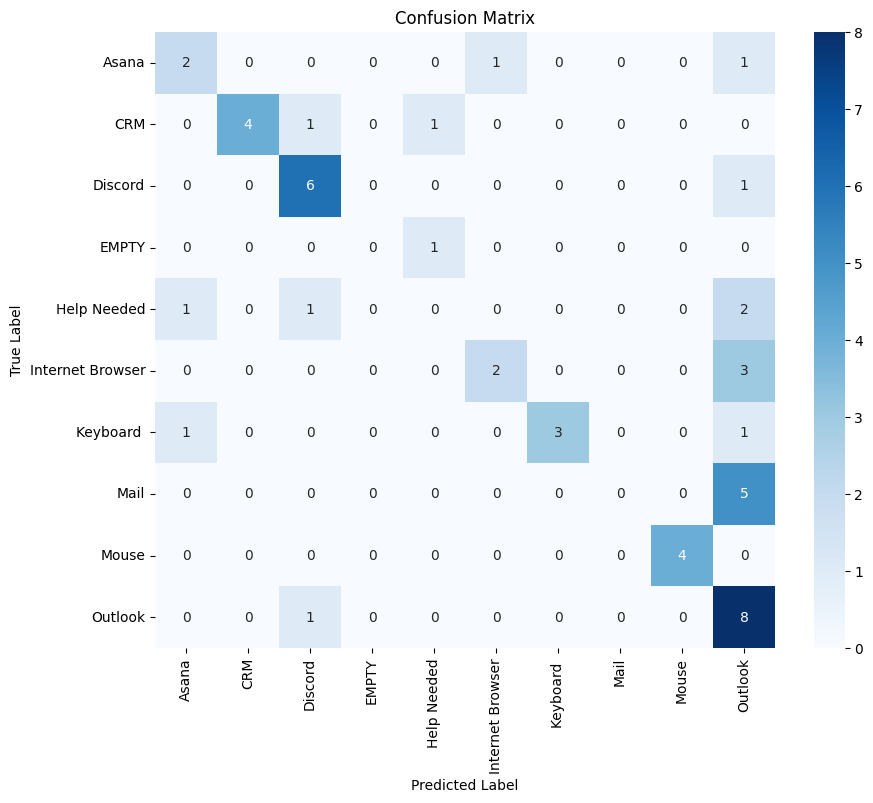

In [16]:
# for each dataset, encoder and classifier, train
# and predict the category

# itsm dataset, sentence transformer and logistic regression
X = itsm_df_focused['Text'].astype(str).fillna('EMPTY').values
y = itsm_df_focused['Category'].fillna('EMPTY')

sorted_y_values = sorted(y.unique())
y_int = y.map({val: i for i, val in enumerate(sorted_y_values)})
print(f'y mapping: {y_int}')

y_mapped = y_int.values

# do a stratified split with 30 test examples
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=50, random_state=42, stratify=y_mapped)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=42, stratify=y)
X_train_encoded = sentence_encoder.encode(X_train)
X_test_encoded = sentence_encoder.encode(X_test)
classifier = LogisticRegression()
classifier.fit(X_train_encoded, y_train)
y_pred = classifier.predict(X_test_encoded)




show_classifier_results(y_test, y_pred, sorted_y_values)


## Classifier for yt dataset


In [17]:
# use the sentence transformer to encode the text
yt_df.head(), yt_df.shape

(                                             Comment Sentiment
 0  lets not forget that apple pay in 2014 require...   neutral
 1  here in nz 50 of retailers don’t even have con...  negative
 2  i will forever acknowledge this channel with t...  positive
 3  whenever i go to a place that doesn’t take app...  negative
 4  apple pay is so convenient secure and easy to ...  positive,
 (18408, 2))

In [18]:
import textwrap
for i in range(10):
    # print(f'Comment {i}: {yt_df.iloc[i, 0]}')
    print(textwrap.fill(yt_df.iloc[i, 0], 80))
    print(f'Category: {yt_df.iloc[i, 1]}')
    print('')


lets not forget that apple pay in 2014 required a brand new iphone in order to
use it a significant portion of apples user base wasnt able to use it even if
they wanted to as each successive iphone incorporated the technology and older
iphones were replaced the number of people who could use the technology
increased
Category: neutral

here in nz 50 of retailers don’t even have contactless credit card machines like
paywave which support apple pay they don’t like the high fees that come with
these
Category: negative

i will forever acknowledge this channel with the help of your lessons and ideas
explanations now its quite helpful while youll just sit at your comfort and
monitor your account growth
Category: positive

whenever i go to a place that doesn’t take apple pay doesn’t happen too often
it’s such a drag between ‘contactless covid’ habits and my getting the apple
card i’ve gotten so used to apple pay that i get seriously annoyed when a store
doesn’t take it it feels like a shock it

### Sentence encoder, Logreg


In [19]:
# select the text and category columns
X = yt_df['Comment'].astype(str).fillna('EMPTY').values
y = yt_df['Sentiment'].fillna('EMPTY')
print(f'X.shape: {X.shape}, y.shape: {y.shape}' )

# show possible y values, sorted
sorted_y_values = sorted(y.unique())
print(f'possible y values: {sorted_y_values}')

# map y values to int
y_int = y.map({val: i for i, val in enumerate(sorted_y_values)})
print(f'y mapping: {y_int}')

y_mapped = y_int.values


# do a stratified split with 30 test examples
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=500, random_state=42, stratify=y_mapped)
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}, y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}')

X_train_encoded = sentence_encoder.encode(X_train)
X_test_encoded = sentence_encoder.encode(X_test)

X.shape: (18408,), y.shape: (18408,)
possible y values: ['negative', 'neutral', 'positive']
y mapping: 0        1
1        0
2        2
3        0
4        2
        ..
18403    2
18404    2
18405    1
18406    2
18407    2
Name: Sentiment, Length: 18408, dtype: int64
X_train.shape: (17908,), X_test.shape: (500,), y_train.shape: (17908,), y_test.shape: (500,)


In [20]:
classifier = LogisticRegression()
classifier.fit(X_train_encoded, y_train)

LogisticRegression()

possible y values: ['negative', 'neutral', 'positive']
y_train distribution: [ 2275  4512 11121]
y_test distribution: [ 63 126 311]
Accuracy: 0.774
Confusion matrix: [[ 34  19  10]
 [ 13  78  35]
 [  6  30 275]]
Classification report:               precision    recall  f1-score   support

           0       0.64      0.54      0.59        63
           1       0.61      0.62      0.62       126
           2       0.86      0.88      0.87       311

    accuracy                           0.77       500
   macro avg       0.71      0.68      0.69       500
weighted avg       0.77      0.77      0.77       500



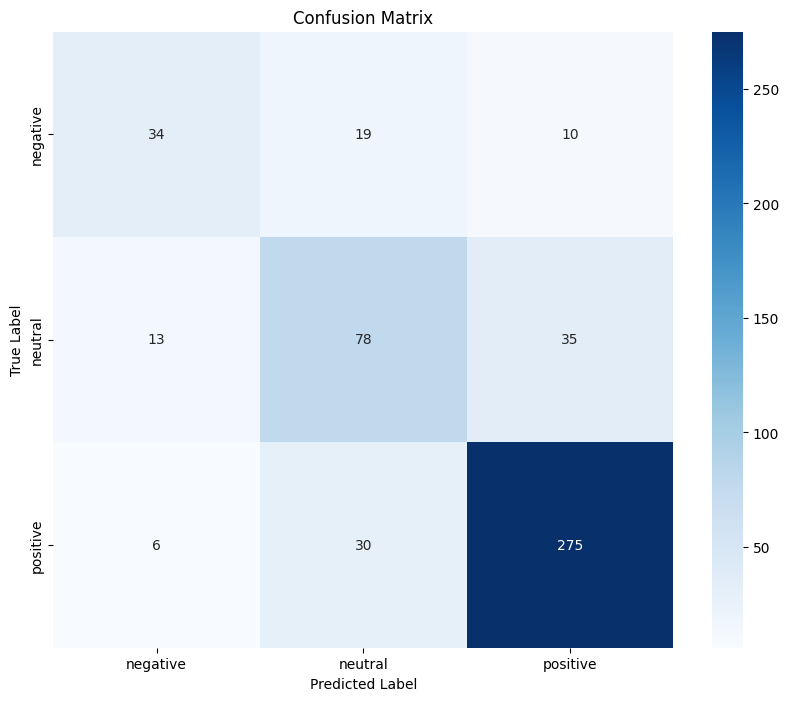

In [21]:

print(f'possible y values: {sorted_y_values}')
y_pred = classifier.predict(X_test_encoded)
print(f'y_train distribution: {np.bincount(y_train)}')
print(f'y_test distribution: {np.bincount(y_test)}')
show_classifier_results(y_test, y_pred, sorted_y_values)




### Sentence encoder, MLP

In [22]:
# train a MLP classifier

mlp_model = train_mlp(X_train_encoded, y_train)






Epoch 1/10, Loss: 0.5930528044700623
Epoch 2/10, Loss: 0.4967350959777832
Epoch 3/10, Loss: 0.30091896653175354
Epoch 4/10, Loss: 0.611718475818634
Epoch 5/10, Loss: 0.5727651715278625
Epoch 6/10, Loss: 0.42822471261024475
Epoch 7/10, Loss: 0.2828018367290497
Epoch 8/10, Loss: 0.5118206143379211
Epoch 9/10, Loss: 0.397352397441864
Epoch 10/10, Loss: 0.5389403700828552


Accuracy: 0.792
Confusion matrix: [[ 36  18   9]
 [  9  86  31]
 [  5  32 274]]
Classification report:               precision    recall  f1-score   support

           0       0.72      0.57      0.64        63
           1       0.63      0.68      0.66       126
           2       0.87      0.88      0.88       311

    accuracy                           0.79       500
   macro avg       0.74      0.71      0.72       500
weighted avg       0.79      0.79      0.79       500



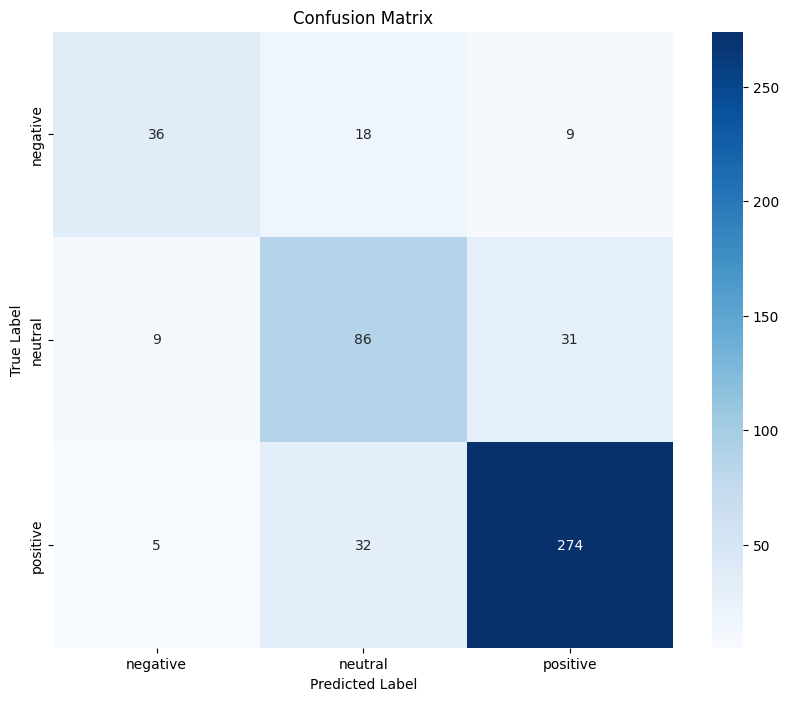

In [23]:
# test MLP classifier
y_pred = predict_mlp(mlp_model, X_test_encoded)
show_classifier_results(y_test, y_pred, sorted_y_values)





## Same, but with tf-idf

In [24]:
# encode the text with tf-idf
X_train_tfidf = tf_idf_encoder.fit_transform(X_train)
X_test_tfidf = tf_idf_encoder.transform(X_test)




In [25]:
# type(X_train_tfidf)#.shape, X_test_tfidf.shape
# # convert to numpy
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()


Accuracy: 0.742
Confusion matrix: [[ 16  25  22]
 [  9  77  40]
 [  5  28 278]]
Classification report:               precision    recall  f1-score   support

           0       0.53      0.25      0.34        63
           1       0.59      0.61      0.60       126
           2       0.82      0.89      0.85       311

    accuracy                           0.74       500
   macro avg       0.65      0.59      0.60       500
weighted avg       0.73      0.74      0.73       500



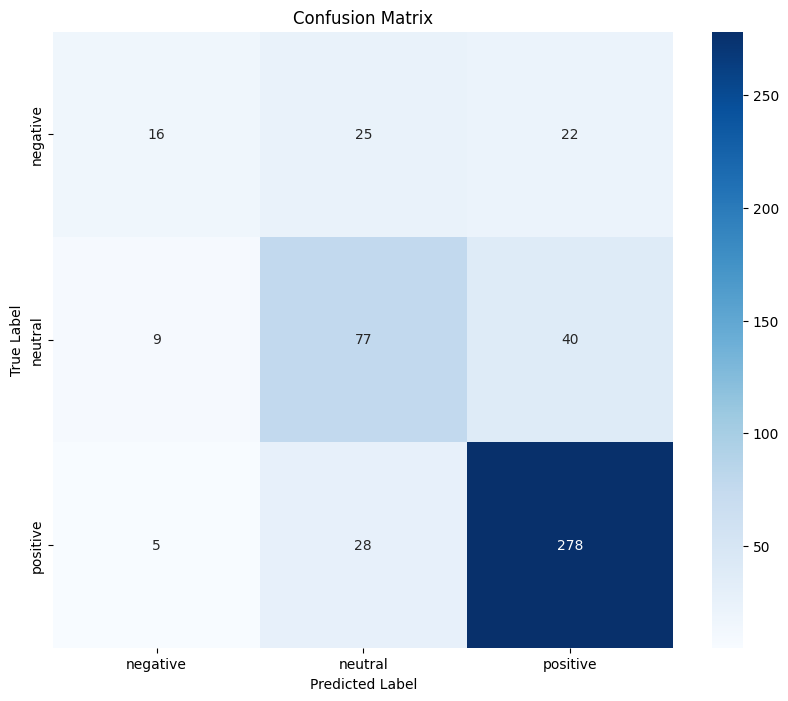

In [26]:
# train a logistic regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)
y_pred = lr_classifier.predict(X_test_tfidf)
show_classifier_results(y_test, y_pred, sorted_y_values)



In [27]:
# same for MLP
mlp_classifier = train_mlp(X_train_tfidf, y_train)
y_pred = predict_mlp(mlp_classifier, X_test_tfidf)
show_classifier_results(y_test, y_pred)






Epoch 1/10, Loss: 0.7110699415206909
Epoch 2/10, Loss: 0.688111424446106
Epoch 3/10, Loss: 0.6769195795059204
Epoch 4/10, Loss: 0.5480508208274841
Epoch 5/10, Loss: 0.8120903968811035
Epoch 6/10, Loss: 0.5007117390632629
Epoch 7/10, Loss: 0.6980260610580444
Epoch 8/10, Loss: 0.6600497961044312
Epoch 9/10, Loss: 0.4913746416568756
Epoch 10/10, Loss: 0.5870431065559387


TypeError: show_classifier_results() missing 1 required positional argument: 'sorted_y_values'

## Lets take a look at the embeddings, and project them to 2D


/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


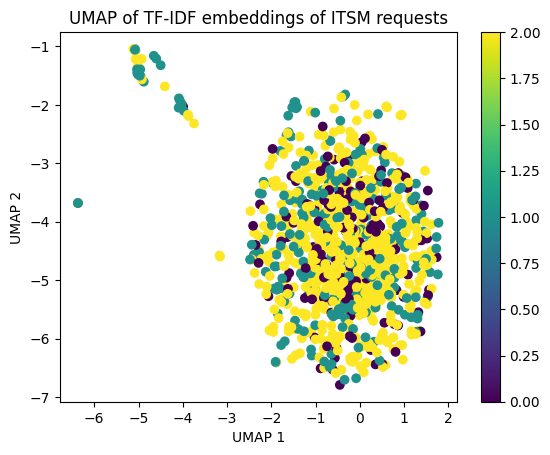

In [ ]:
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)
X_train_tfidf_2d = umap_model.fit_transform(X_train_tfidf[:1000])
# X_test_tfidf_2d = umap_model.transform(X_test_tfidf[:1000])

# plot the embeddings
import matplotlib.pyplot as plt
plt.scatter(X_train_tfidf_2d[:, 0], X_train_tfidf_2d[:, 1], c=y_train[:1000], cmap='viridis')
plt.colorbar()
# plt.show()
# create a caption for the plot, describe what the colors represent
plt.title('UMAP of TF-IDF embeddings of ITSM requests')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


In [ ]:
# import torch
# from sentence_transformers import SentenceTransformer

# # Each query needs to be accompanied by an corresponding instruction describing the task.
# task_name_to_instruct = {"example": "Classify the sentiment as positive, negative, neutral",}

# passage_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "

# passages = X_train[:100]
# # load model with tokenizer
# nv_model = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
# nv_model.max_seq_length = 32768
# nv_model.tokenizer.padding_side="right"

# def add_eos(input_examples):
#   input_examples = [input_example + nv_model.tokenizer.eos_token for input_example in input_examples]
#   return input_examples

# # get the embeddings
# batch_size = 2
# # query_embeddings = model.encode(add_eos(queries), batch_size=batch_size, prompt=query_prefix, normalize_embeddings=True)
# passage_embeddings = nv_model.encode(add_eos(passages), batch_size=batch_size,prompt=passage_prefix, normalize_embeddings=True)

# # scores = (query_embeddings @ passage_embeddings.T) * 100
# # print(scores.tolist())


## OpenAI embeddings



In [ ]:
from openai import OpenAI
# get key from .env
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

prefix = "Classify the sentiment of this text as POSITIVE, NEGATIVE, or NEUTRAL: "

# embed 100 of the sentences in X_train
X_embeddings = []
# sample 50 idx
train_idx_sample = np.random.choice(len(X_train), 2000, replace=False)
test_idx_sample = np.random.choice(len(X_test), 300, replace=False)

X_train_sample = X_train[train_idx_sample]
X_test_sample = X_test[test_idx_sample]
y_train_sample = y_train[train_idx_sample]
y_test_sample = y_test[test_idx_sample]

for text in X_train_sample:
    # response = client.embeddings.create()   
    response = client.embeddings.create(
        input=prefix + text,
        # model="text-embedding-3-small"
        model = "text-embedding-3-large"
    )
    X_embeddings.append(response.data[0].embedding)

X_train_embeddings = np.array(X_embeddings)

for text in X_test_sample:
    # response = client.embeddings.create()   
    response = client.embeddings.create(
        input=prefix + text,
        # model="text-embedding-3-small"
        model = "text-embedding-3-large"
    )
    X_embeddings.append(response.data[0].embedding)




In [ ]:
# save embeddings to file
# np.save('../datasets/X_train_embeddings.npy', X_train_embeddings)
# np.save('../datasets/X_test_embeddings.npy', X_test_embeddings)
# X_train_embeddings = np.load('../datasets/X_train_embeddings.npy')
# X_test_embeddings = np.load('../datasets/X_test_embeddings.npy')


In [ ]:
from openai import OpenAI
import numpy as np

# client = OpenAI()

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)


# response = client.embeddings.create(
#     model="text-embedding-3-small", input="Testing 123", encoding_format="float"
# )

# reduce embedding to 256 dimensions

x_embeddings_256 = X_train_embeddings[:, :256]
X_embeddings_256_norm = normalize_l2(x_embeddings_256)

X_embeddings_5 = X_train_embeddings[:, :5]
X_embeddings_5_norm = normalize_l2(X_embeddings_5)

# y_train_sample = y_train_sample.astype(int)



NameError: name 'y_train_sample' is not defined

In [ ]:
# plot the embeddings as above, first with umap
# show the same but for the sentence transformer embeddings
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)
X_train_encoded_2d = umap_model.fit_transform(X_embeddings_5)
# X_train_tfidf_2d = umap_model.fit_transform(X_train_tfidf[:1000])


# plot the embeddings
import matplotlib.pyplot as plt
plt.scatter(X_train_encoded_2d[:, 0], X_train_encoded_2d[:, 1], c=y_train_sample, cmap='viridis')
plt.colorbar()
plt.show()



/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NameError: name 'y_train_sample' is not defined

## Nvidia embeddings

In [ ]:
# from sentence_transformers import SentenceTransformer
# sentence_encoder = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
# sentence_encoder.max_seq_length = 756# 32768
# sentence_encoder.tokenizer.padding_side="right"

/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# # use nvembed
# X = yt_df['Comment'].astype(str).fillna('EMPTY').values
# y = yt_df['Sentiment'].fillna('EMPTY')
# print(f'X.shape: {X.shape}, y.shape: {y.shape}' )
# # map y values to int
# sorted_y_values = sorted(y.unique())

# y_int = y.map({val: i for i, val in enumerate(sorted_y_values)})
# print(f'y mapping: {y_int}')

# # Convert to numpy arrays for consistent indexing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

# n_train_samples = 10
# n_test_samples = 3
# # select random idx
# train_idx_sample = np.random.choice(len(X_train), n_train_samples, replace=False)
# test_idx_sample = np.random.choice(len(X_test), n_test_samples, replace=False)

# X_train_sample = X_train[train_idx_sample]
# y_train_sample = y_train[train_idx_sample]

# X_test_sample = X_test[test_idx_sample]
# y_test_sample = y_test[test_idx_sample]

X.shape: (18408,), y.shape: (18408,)
y mapping: 0        1
1        0
2        2
3        0
4        2
        ..
18403    2
18404    2
18405    1
18406    2
18407    2
Name: Sentiment, Length: 18408, dtype: int64


In [ ]:

# prefix = "Classify the sentiment of this text as POSITIVE, NEGATIVE, or NEUTRAL: "
# # passage_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
# X_train_encoded = sentence_encoder.encode(X_train_sample, instruct = prefix)
# X_test_encoded = sentence_encoder.encode(X_test_sample, instruct = prefix) 

# LLM as a classifier (Classifier agent)

In [ ]:
# pick N random examples from X_test
N = 100
test_idx_sample = np.random.choice(len(X_test), N, replace=False)
X_test_sample = X_test[test_idx_sample]
y_test_sample = y_test[test_idx_sample]

# ask openai to classify the examples

model = 'gpt-4o-mini'

predictions = []
for text, label in zip(X_test_sample, y_test_sample):
    prompt = f"Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: {text}"
    print(f'prompt: {prompt}, y_test_sample: {label}')
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    prediction = response.choices[0].message.content
    text_of_label = sorted_y_values[label]
    print(f"prediction: {prediction}, label: {label}")

    prediction = prediction.strip().lower()
    predictions.append(prediction)

for prediction, label in zip(predictions, y_test_sample):
    print(f"prediction: {prediction}, label: {sorted_y_values[label]}")

predicion_ids = [sorted_y_values.index(prediction) for prediction in predictions]
# predicion_ids

# show classifier results
show_classifier_results(y_test_sample, predicion_ids)



prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: what a god bless movie from the story to line to the characters absolutely beautiful, y_test_sample: 2
prediction: POSITIVE, label: 2
prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: a more effective way for villagers to return at night is an automatic bell alarm using night sensors with linked with a timer that rings thrice it kinds of really reminds me of a clock that has curfew regulations, y_test_sample: 1
prediction: NEUTRAL, label: 1
prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: i don’t even have any allergies but the consciousness of allergens is so comforting idk why  i know it’s really scary traveling with allergies for you gibi so i can imagine how nice it would be to hear those words from a flight attendant, y_test_sa

prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: what a god bless movie from the story to line to the characters absolutely beautiful, y_test_sample: 2
prediction: POSITIVE, label: 2
prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: a more effective way for villagers to return at night is an automatic bell alarm using night sensors with linked with a timer that rings thrice it kinds of really reminds me of a clock that has curfew regulations, y_test_sample: 1
prediction: NEUTRAL, label: 1
prompt: Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: i don’t even have any allergies but the consciousness of allergens is so comforting idk why  i know it’s really scary traveling with allergies for you gibi so i can imagine how nice it would be to hear those words from a flight attendant, y_test_sa

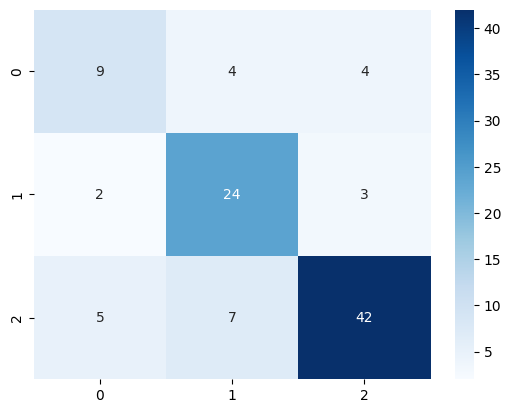

In [ ]:
model = 'gpt-4o'

predictions = []
for text, label in zip(X_test_sample, y_test_sample):
    prompt = f"Classify the sentiment of the following text as POSITIVE, NEGATIVE, or NEUTRAL. Answer only with the category: {text}"
    print(f'prompt: {prompt}, y_test_sample: {label}')
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    prediction = response.choices[0].message.content
    text_of_label = sorted_y_values[label]
    print(f"prediction: {prediction}, label: {label}")
    # map the prediction to the label using sorted_y_values
    # make prediction a string, stripped, lowercase 
    prediction = prediction.strip().lower()
    # prediction = sorted_y_values.index(prediction)
    predictions.append(prediction)
    # y_pred.append(prediction)

for prediction, label in zip(predictions, y_test_sample):
    print(f"prediction: {prediction}, label: {sorted_y_values[label]}")

predicion_ids = [sorted_y_values.index(prediction) for prediction in predictions]
# predicion_ids

# show classifier results
show_classifier_results(y_test_sample, predicion_ids)


In [ ]:
# model = 'gpt-4.5-preview-2025-02-27'






## Classifier V2, going deeper

In [ ]:
# split intent_df into train and test
from sklearn.model_selection import train_test_split
# dont do this at home :) always choose an absolute value for test size
train_df, test_df = train_test_split(itsm_df_focused, test_size=0.2, random_state=42)

train_labels = train_df['Category'].values
distinct_cats = set(train_labels)
distinct_cats

prompt_template = """You are an ITSM agent. Your job is to classify the text into one of the following categories:
<CATEGORIES>
{{categories}} </CATEGORIES>. 
Here is an ITSM ticket. Please classify it into one of the categories.
<REQUEST>
{{request}} </REQUEST>. Please answer with the category. 
When in doubt among two categories, one more general and one
more specific, pick the more specific one. For example if Mail and Outlook are both reasonable options, pick Outlook.
If you do not know the answer, please type 'I do not know'.
"""
example_id = 3
# use jinja2 to fill in the prompt
from jinja2 import Template
template = Template(prompt_template)
categories = ', '.join(distinct_cats)
request = test_df.iloc[example_id]['Text']
print(f'true label: {test_df.iloc[example_id]["Category"]}')
prompt = template.render(categories=categories, request=request)
print(prompt)


true label: Outlook


In [ ]:
response: ChatResponse = chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': 'user',
    'content': prompt,
  },
])
# print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

<think>
Okay, I need to classify this ticket request into one of the given categories. Let me look at it carefully.

The ticket asks to give blockaded attachments from a mail they received by email: name.nachname@firma.com. The reason is that these data are needed for brainstorming the business strategy. 

Looking at the categories, I have empty, keyboard, Discord, CRM, Outlook, Internet Browser, Mail, Asana, Mouse, and Help Needed.

The main issue here seems to be handling attachments in emails. There's no direct mention of attachments or any specific tool related to them. So, the most fitting category is Mail since it's about handling data from an email address.

I don't think it fits into CRM (Customer Relationship Management), Outlook because those are separate applications used for different purposes. Similarly, Stack Overflow isn't relevant here. Asana and Mouse aren't mentioned either, so I can rule them out. Help Needed could be possible if the user has specific questions, but 

In [ ]:
response: ChatResponse = chat(model='qwen2.5:14b', messages=[
  {
    'role': 'user',
    'content': prompt,
  },
])
# print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

Outlook


In [ ]:
# lets try with openAI
model = 'gpt-4o-mini'
response = client.chat.completions.create(
    model=model,
    messages=[{"role": "user", "content": prompt}],
)
prediction = response.choices[0].message.content
print(prediction)

Mail


In [ ]:
# lets try with openAI
model = 'gpt-4o'
response = client.chat.completions.create(
    model=model,
    messages=[{"role": "user", "content": prompt}],
)
prediction = response.choices[0].message.content
print(prediction)

Mail


In [ ]:
# lets try with openAI
model = 'o1-preview'
response = client.chat.completions.create(
    model=model,
    messages=[{"role": "user", "content": prompt}],
)
prediction = response.choices[0].message.content
print(prediction)

Outlook


# Create a classification agent

In [ ]:
class ClassificationAgent:
    def __init__(self, model='gpt-4o'):
        self.model = model
        self.client = OpenAI(api_key=OPENAI_API_KEY)

    def classify(self, prompt):
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
        )
        prediction = response.choices[0].message.content
        return prediction
    
    def classify_ticket(self, ticket, distinct_cats=None):
        categories = ', '.join(distinct_cats)
        request = ticket
        prompt = template.render(categories=categories, request=request)
        return self.classify(prompt)
    


# Clustering and output

In [ ]:
# cluster with bertopic and visualize
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')


topic_model = BERTopic(language="english", calculate_probabilities=True, vectorizer_model=vectorizer)
topics, probs = topic_model.fit_transform(intent_df['Text'].values)

# get the most frequent topics
topic_freq = topic_model.get_topic_info()
topic_freq.head()




# plot a barchart of the most frequent topics along with their keywords
# please do show the keywords in the plot

topic_info = topic_model.get_topic_info()
topics = topic_model.get_topics()

print(f'Number of clusters: {len(topic_info)}')
print (topic_info[['Topic', 'Count']] [:20])



fig = topic_model.visualize_barchart(top_n_topics=20)
fig.update_layout(title=f"Cluster distribution")







OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Number of clusters: 5
   Topic  Count
0     -1      6
1      0     45
2      1     39
3      2     14
4      3     14


# LLM as a clusterer (clustering agent)

In [ ]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
# print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

<think>

</think>

The color of the sky, also known as atmospheric transparency, primarily depends on the amount of blue light (blue radiation) in the atmosphere. Blue light has a shorter wavelength than red or orange light, which means it travels through the Earth's atmosphere more slowly and can scatter off small particles such as dust and water droplets. When sunlight enters Earth's atmosphere, some of its blue component is scattered back towards us, causing the sky to appear blue.

However, this scattering effect also leads to a phenomenon called Rayleigh scattering. Light with an average wavelength in the atmosphere scatters less frequently and can pass through, resulting in the sky appearing more transparent than pure blue light would suggest. This combination of factors gives us the impression that the sky is blue.


## LLM as classifier

true label: Outlook


<think>
Okay, so I need to classify this ITSM ticket into one of the given categories: EMPTY, Mouse, Internet Browser, CRM, Discord, Keyboard , Asana, Outlook, Help Needed, Mail. 

First, looking at the text provided. The request is in German and says:

" Bitte geben Sie blockierte Anhänge aus derMail, die ich von name.nachname@firma.comfriedrich.de. Dies sind Daten, die für das Brainstorming der Vertriebsstrategie benötigt werden."

Breaking this down: It's asking for blocked attachments from a specific email address. The user has provided an example of their email (name.nachname@firma.comfriedrich.de) but the exact details are in a box. They mention that these data are needed for brainstorming the distribution strategy.

Now, considering the categories:

- EMPTY: Doesn't fit because it's not empty.
- Mouse: Also doesn't fit; no mouse involved here.
- Internet Browser: Unlikely since it's about attachments and email addresses.
- CRM: Not directly related unless there's a need to manag

Outlook


# Gen AI to cluster

In [ ]:
clustering_template = """You are an ITSM agent. Your job is to group the following ITSM requests into groups, and give a name to each group.
Here is the list of enumerated ITSM requests:
<REQUEST>
{{request}} 
</REQUEST>.

Please answer with a JSON dict where the keys are group names, and the values are list of IDs of requests that belong to that group.
The json looks like this:
{
  "group 1": [1, 2, 3],
  "group 2": [4, 5, 6]
}

"""

In [ ]:
# get the first 10 requests
requests = test_df['Text'].values[:10]
requests = '\n'.join([f'{i+1}. {r}' for i, r in enumerate(requests)])
prompt = Template(clustering_template).render(request=requests)
print(prompt)

You are an ITSM agent. Your job is to group the following ITSM requests into groups, and give a name to each group.
Here is the list of enumerated ITSM requests:
<REQUEST>
1. Mail is not working, I can't open it. Please help. I also get a lot of spam emails when it's working, please install some spam blocker as well.
2. Bitte reparieren Sie mein Hubspot CRM. Seit gestern funktioniert es nicht mehr
3. Discor needed for instalation.
4. <p> Bitte geben Sie blockierte Anhänge aus der Mail frei, die ich von name.nachname@firma.com erhalten habe. Dies sind Daten, die für das Brainstorming der Vertriebsstrategie benötigt werden. </p>
5. Microsoft Outlook doesn't work. I can't send or recieve any mails. Please help.
6. Please send the new keyboard to my home address for home office: City, Street 12, Flat: Surname.
7. Our CRM stopped to work again. I can't start it.
8. Please install Discord on my PC. I also have issues with Powerpoint and I need a new mouse. I don't want to follow stupid instr

In [ ]:
response: ChatResponse = chat(model='qwen2.5:14b', messages=[
  {
    'role': 'user',
    'content': prompt,
  },
])
# print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

{
  "Email Issues": [1, 5, 9],
  "CRM Problems": [2, 7, 10],
  "Discord Requests": [3, 8],
  "Specific Email Request": [4],
  "Hardware Request": [6]
}
